# Lab 3 — dimensionality reduction

In [53]:
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

### Explore using Hadoop

In [2]:
!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 2

{"genres": ["(no genres listed)"], "movieId": 131260, "title": "Rentun Ruusu (2001)"}
{"genres": ["Adventure", "Fantasy", "Horror"], "movieId": 131262, "title": "Innocence (2014)"}


In [3]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | head -n 2

{"tagId": 1, "tag": "007"}
{"tagId": 2, "tag": "007 (series)"}


In [4]:
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 2

{"relevance": 0.11449999999999999, "tagId": 1127, "movieId": 131170}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}


In [5]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


### Create RDDs

In [83]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)

AttributeError: 'list' object has no attribute 'textFile'

In [7]:
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)

In [8]:
scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

In [9]:
ratings = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

In [10]:
tag2name = dict(tags.map(itemgetter("tagId", "tag")).collect())

#### How many different movies are there? How many tags, tag scores, movie ratings?

Just use `count` function on above RDDs.

#### Check every movies has at leat one given genre (no genre is a genre)

In [ ]:
movies.count()

In [ ]:
movies.filter(lambda x: len(x['genres']) > 0).count()

#### How many movies have at least one tag?

In [11]:
rdd = scores.map(lambda x: x['movieId']).distinct()

In [12]:
mvs = np.array(rdd.collect())

In [79]:
mvs[-5:]

array([36401, 36509, 36527, 36533, 37211])

In [ ]:
len(mvs)

#### How many different movie genres are there?

In [ ]:
def func_seqOp(s, m):
    s.update(m['genres'])
    return s

In [ ]:
seqOp = func_seqOp
combOp = (lambda s1, s2: s1.union(s2))

In [ ]:
movies.aggregate(set(), seqOp, combOp)

#### What are the shortest and longest movie titles? Tag names?

In [ ]:
movies.reduce(lambda x,y: x if len(x['title']) > len(y['title']) else y)['title']

In [ ]:
movies.reduce(lambda x,y: x if len(x['title']) < len(y['title']) else y)['title']

In [ ]:
tags.reduce(lambda x,y: x if len(x['tag']) > len(y['tag']) else y)['tag']

In [ ]:
tags.reduce(lambda x,y: x if len(x['tag']) < len(y['tag']) else y)['tag']

# Dimensionality reduction (using RDD & index)

In [ ]:
mvsl = list(mvs) # list of movies that have at least one tag in sorted order

In [9]:
n_rows = len(tag2name.values())
n_cols = len(mvs)

In [10]:
M = np.zeros(shape=(n_rows, n_cols))

In [ ]:
def cool(m, s):
    row = s['tagId'] - 1
    col = mvsl.index(s['movieId'])
    m[row][col] = s['relevance']
    return m

In [ ]:
seqOp = cool
combOp = (lambda m1, m2: m1 + m2)

In [ ]:
M = scores.aggregate(M, seqOp, combOp)

# Dimensionality reduction (using RDD)

In [36]:
def cool2(m, s):
    row = s['tagId'] - 1
    col = m[1] if s['movieId'] == m[2] else m[1] + 1
    mid = m[2] if s['movieId'] == m[2] else s['movieId']
    m[0][row][col] = s['relevance']    
    return (m[0], col, mid)

In [37]:
M, ind, mid = scores.fold((M, 0, 1), cool2)

KeyboardInterrupt: 

# Dimensionality reduction (using np)

In [13]:
n_rows = len(tag2name.values())
n_cols = len(mvs)

In [14]:
M = np.zeros(shape=(n_rows, n_cols))

In [15]:
sc = scores.map(itemgetter("relevance", "tagId", "movieId")).collect()

In [16]:
sc[0:5]

[(0.025000000000000022, 1, 1),
 (0.025000000000000022, 2, 1),
 (0.057750000000000024, 3, 1),
 (0.09675, 4, 1),
 (0.14675, 5, 1)]

In [17]:
def populate(M, sc):
    cur = sc[0][2] # first movie ID
    col = 0 # first col index
    
    for s in sc:
        row = s[1] - 1
        col = col if s[2] == cur else col + 1
        cur = cur if s[2] == cur else s[2]
        M[row][col] = s[0]
    
    return M

In [18]:
M = populate(M, sc)

### Compute variances

In [23]:
var = np.zeros(M.shape[0])

In [24]:
for i in range(M.shape[0]):
    var[i] = np.var(M[i])

In [22]:
var = np.sort(var)

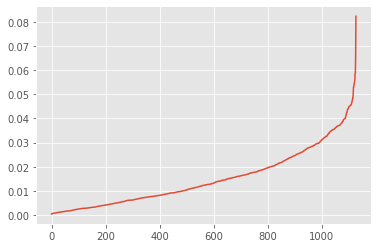

In [23]:
plt.plot(var)

### Compute covariances

In [25]:
cov = np.cov(M)

In [30]:
cov[456][456]

0.009479722917993753

In [31]:
var[456]

0.009478809737864864

In [32]:
eig, eigv = np.linalg.eigh(cov)

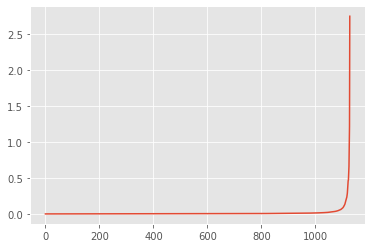

In [33]:
plt.plot(eig)

In [34]:
2 * np.sum(eig) / 3

11.401262159927777

In [29]:
np.sum(eig[-37:])

11.455683688345397

In [35]:
diag = np.linalg.inv(eigv)@cov@eigv

In [36]:
a = np.diagonal(diag)

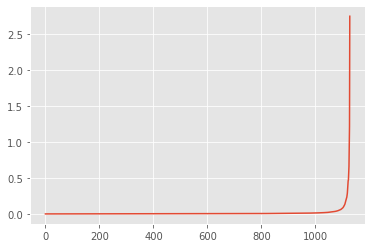

In [37]:
plt.plot(a)

In [41]:
eig[-5:]

array([0.58572979, 0.6621755 , 0.99605152, 1.22147104, 2.75337748])

In [42]:
eigv[-5:]

array([[ 0.00427381,  0.00042275, -0.00413977, ...,  0.0022564 ,
         0.00318406,  0.01704651],
       [ 0.00381773, -0.00197056,  0.00295495, ..., -0.00577411,
        -0.00253256,  0.00509374],
       [ 0.00093566, -0.00050236,  0.00263286, ...,  0.03252862,
        -0.00551248,  0.01719115],
       [-0.00228662,  0.01518848,  0.00429738, ..., -0.0399581 ,
        -0.01417361, -0.01026643],
       [ 0.00059397, -0.01100711, -0.00067457, ..., -0.01634403,
        -0.00551606, -0.00137267]])

## Concept space

In [43]:
dims = 5

In [44]:
for i in range(dims):
    print(f'For eigenvalue : {eig[-i-1]}')
    
    indt = eigv[-i-1].argsort()[-10:][::-1]
    print('Best tags in order are')
    for ind in indt:
        print(f'\t {tag2name.get(ind)}')
    
    indw = eigv[-i-1].argsort()[:10]
    print('Worst tags in order are')
    for ind in indw:
        print(f'\t {tag2name.get(ind)}')
    print('\n')

For eigenvalue : 2.7533774797813493
Best tags in order are
	 assassins
	 based on a book
	 awesome soundtrack
	 aviation
	 product placement
	 sad but good
	 beer
	 cancer
	 bdsm
	 australian
Worst tags in order are
	 arnold
	 bad acting
	 astronauts
	 awful
	 surveillance
	 argentina
	 art
	 slow paced
	 bullshit history
	 space program


For eigenvalue : 1.2214710425886666
Best tags in order are
	 arnold
	 bad acting
	 astronauts
	 awful
	 australia
	 argentina
	 assassin
	 apocalypse
	 art
	 books
Worst tags in order are
	 assassins
	 awesome soundtrack
	 based on a book
	 aviation
	 australian
	 bdsm
	 atheism
	 cia
	 beer
	 bank robbery


For eigenvalue : 0.9960515193084871
Best tags in order are
	 bad acting
	 awful
	 bad ending
	 atmospheric
	 astronauts
	 aviation
	 autism
	 australia
	 watch the credits
	 artificial intelligence
Worst tags in order are
	 artsy
	 assassination
	 bad
	 bad plot
	 author:alan moore
	 bad script
	 based on a true story
	 assassin
	 western
	 based

In [46]:
tagscoords = {}

In [50]:
for i in tag2name:
    coords = []
    for j in range(5):
        coords.append(eigv[-j-1][i-1])
    tagscoords[tag2name.get(i)] = coords

In [56]:
file = open("tagscoord.pkl", "wb")
pickle.dump(tagscoords, file)
file.close()

In [57]:
a_file = open("tagscoord.json", "w")
json.dump(tagscoords, a_file)
a_file.close()

## Movie visualization

In [66]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

In [60]:
with open("selected-movies.pickle", "rb") as f:
    mvspkl = pickle.load(f, encoding="utf-8")

In [70]:
b1 = eigv[-1]
b2 = eigv[-2]

In [74]:
coordinates = {}

In [ ]:
for i in range(len(mvspkl)):
    idm = movies.filter(lambda x: x['title'] == mvspkl[i]).collect()['movieId']
    ind = np.where(idm == mvs)[0][0]
    coordinates[mvspkl[i]] = list([b1@M.T[ind], b2@M.T[ind]])